In [116]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import copy
import time

In [134]:
CMAP = ListedColormap(['white','royalblue','orange','saddlebrown','purple','deepskyblue','pink','yellow','dodgerblue','slategray','green','lightgreen','red'])
def print_board(board):
    plt.imshow(board,cmap=CMAP,vmin=0,vmax=12)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [126]:
def first_empty(row):
    occupied = row > 0
    if np.all(occupied):
        return None
    return occupied.tolist().index(False)

def first_non_empty(row):    
    if np.sum(row) == 0:
        return None
    occupied = row > 0
    return occupied.tolist().index(True) 

def shift_upper_left(shape):
    #shift up
    news = np.copy(shape)
    for axis in [0,1]:
        sums = shape.sum(axis=axis)     
        i = first_non_empty(sums) # what index has nonzero
        news = np.roll(news,-i,axis= 1 - axis)
    return news
def matrix_strip(m):
    newm = m[~np.all(m == 0, axis=1)]
    return newm[:,~np.all(newm == 0, axis=0)]

def get_piece_orientations(shape):
    orient = [copy.deepcopy(shape)]
    for flip in [False,True]:
        newshape = copy.deepcopy(shape)
        if flip:
            newshape = np.flip(newshape,axis=0)
            orient.append(newshape)
        for angle in [90,180,270]:
            orient.append(np.rot90(newshape,k=angle/90))
            
    orient = [matrix_strip(shift_upper_left(s)) for s in orient]
    unique = [orient[0]]
    for p in orient[1:]:
        # check that p in not in orient
        can_add = True
        for p2 in unique:
            if p.shape == p2.shape and np.all(p==p2):
                can_add = False
        if can_add:    
            unique.append(p)
    return unique

In [127]:
class PIECE:
    def __init__(self,shape,value=None):
        self.shape=np.array(shape)
        if value is not None:
            self.value=value
            self.shape = self.shape*value
        else:
            self.value = np.max(shape)
        
        self.orientations = get_piece_orientations(self.shape)
        
    def display(self):
        plt.title(f"Piece {self.value}")
        print_board(self.shape)
        
    

In [128]:
PIECES = {}
PIECES[1] = PIECE([[1,1,1,1,1]])
PIECES[2] = PIECE([[1,1,1,1,0],
                   [0,0,0,1,0]],2)
PIECES[3] = PIECE([[1,1,1,1,0],
                   [0,0,1,0,0]],3)
PIECES[4] = PIECE([[1,1,1,0,0],
                   [0,0,1,1,0]],4)
PIECES[5] = PIECE([[1,1,1,0,0],
                   [0,0,1,0,0],
                   [0,0,1,0,0]],5)
PIECES[6] = PIECE([[1,1,1,0,0],
                   [0,1,1,0,0]],6)
PIECES[7] = PIECE([[1,1,1,0,0],
                   [1,0,1,0,0]],7)
PIECES[8] = PIECE([[0,0,1,0,0],
                   [1,1,1,0,0],
                   [1,0,0,0,0]],8)
PIECES[9] = PIECE([[0,1,0,0,0],
                   [1,1,1,0,0],
                   [1,0,0,0,0]],9)
PIECES[10] = PIECE([[1,1,1,0,0],
                    [0,1,0,0,0],
                    [0,1,0,0,0]],10)
PIECES[11] = PIECE([[1,1,0,0,0],
                    [0,1,1,0,0],
                    [0,0,1,0,0]],11)
PIECES[12] = PIECE([[0,1,0,0,0],
                    [1,1,1,0,0],
                    [0,1,0,0,0]],12)

In [129]:
def valid_placement(board,shape,r,c):
    #check that piece does not go off board or overlap with any other pieces
    nrows,ncols = shape.shape
    
    if nrows + r > board.shape[0]:
        return False
    if ncols + c > board.shape[1]:
        return False    
    
    if np.any(board[r:r+nrows,c:c+ncols] * shape):
        return False

    return True

def flood_fill(matrix,r,c,empty=0,fill=-1):
    if r >= matrix.shape[0] or r < 0:
        return matrix
    if c >= matrix.shape[1] or c < 0:
        return matrix
    if matrix[r,c] == empty:
        matrix[r,c] = fill
        matrix = flood_fill(matrix,r,c+1)
        matrix = flood_fill(matrix,r,c-1)
        matrix = flood_fill(matrix,r+1,c)
        matrix = flood_fill(matrix,r-1,c)
    return matrix

#find first unoccupied
def flood(matrix,empty=0,fill=-1):
    nrows,ncols = matrix.shape    
    for r in range(nrows):     
        for c in range(ncols-1,-1,-1):
            if matrix[r,c] == empty:
                return flood_fill(matrix,r,c,empty,fill)
    return matrix    

def contains_holes(board):
    #flood from right most column and then compare counts?
    flooded = flood(board.copy(),fill=-1)
    nflooded = np.sum(flooded == -1)    
    occupied = np.sum(board > 0)
    #return (nflooded % 5) != 0
    return nflooded + occupied != board.size
    

def find_boards(board,shape) -> list[np.array]:
    first_row = first_non_empty(shape[:,0]) #first non-empty row 
    #for every row note the left most open square and try to put top-left index of piece there, if its a valid place then make that as a board
    # otherwise return none
    
    boards = []
    for row in range(first_row,board.shape[0]):
        col = first_empty(board[row])
        if col == None: #all filled
            continue
        row_to_place = row - first_row #in case 0,0 is not a value of a piece
        if valid_placement(board,shape,row_to_place,col):
            newb = board.copy()
            newb[row_to_place:row_to_place + shape.shape[0],col:col + shape.shape[1]] += shape          
            #plt.title(f"find: {contains_holes(newb)}")
            #print_board(newb)
            if contains_holes(newb):
                #print("Rejecting: ")
                #print_board(newb)
                continue
            boards.append(newb)
    return boards

In [130]:
m = np.zeros((5,12))
m[:,5:] = 2
m[1:4,1:4] = 5
contains_holes(m)

False

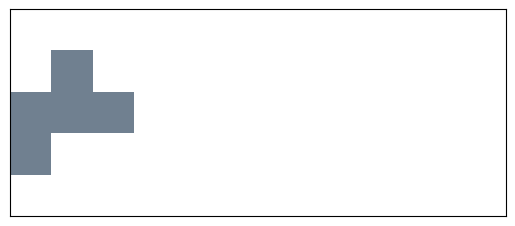

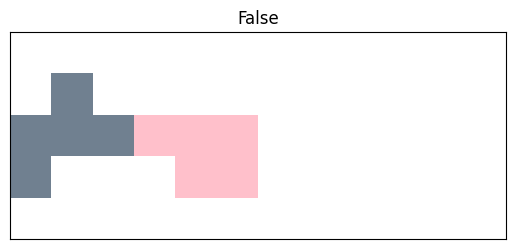

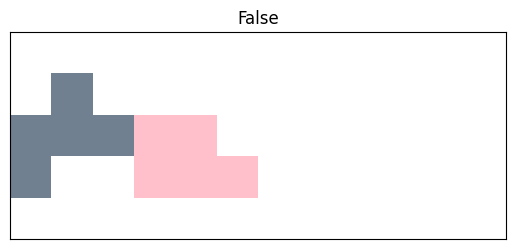

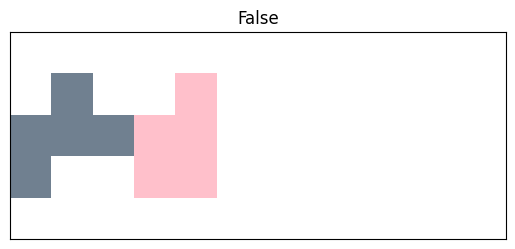

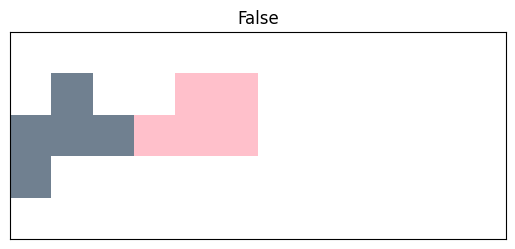

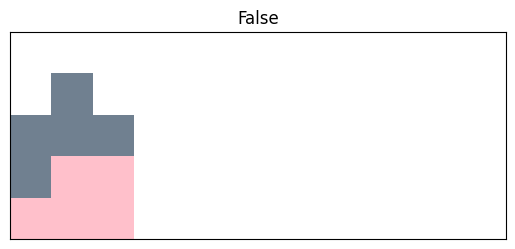

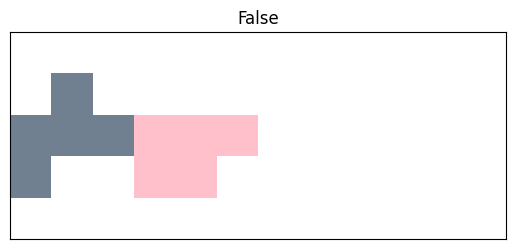

In [135]:
brds = find_boards(np.zeros((5,12)),PIECES[9].shape)
print_board(brds[0])
for shape in PIECES[6].orientations:
    bs = find_boards(brds[0],shape)
    for b in bs:
        plt.title(contains_holes(b))
        print_board(b)

In [122]:
class PathFinder:
    def __init__(self,start_state,check_done,transition_func,hash_func,debug=False):
        self.start = start_state
        self.check_done = check_done
        self.transition = transition_func
        self.visited = set()
        self.hash = hash_func
        self.debug = debug
    
    def DFS(self):
        self.start_time = time.time()
        self.counter = 0
        solution = self.DFS_helper(self.start)
        print(f"{self.counter} states searched in {time.time() - self.start_time:.2f} seconds")
        if solution is None:
            print(f"No solution found")
        else:
            board,pieces = solution
            print_board(board)
    
    def DFS_helper(self,start):
        self.counter += 1
        if self.debug:
            print(f"{time.time() - self.start_time:.2f} sec. Attempt {self.counter}")
            print_state(start)
        if self.check_done(start):
            return start
        new_states = self.transition(start)
        for state in new_states:
            s_hash = self.hash(state)
            if s_hash in self.visited:
                continue
            self.visited.add(s_hash)
            assert state is not None
            solution = self.DFS_helper(state)
            if solution is not None:
                return solution

In [123]:
def print_state(state):
    plt.title(state[1])
    print_board(state[0])

def hash_func(state):
    board,pieces = state
    ll = board.flatten().tolist() + pieces
    return "".join([str(x) for x in ll])
# returns list of next possible states
def transition_func(state):
    board,piece_nums = state
    if len(piece_nums)==0:
        return []
    new_states = []
    for i in range(len(piece_nums)):
        p = PIECES[piece_nums[i]]
        rest_nums = piece_nums[:i] + piece_nums[i+1:]
        boards = []  
        for shape in p.orientations:
            boards.extend(find_boards(board,shape))
            new_states.extend([(b,rest_nums) for b in boards])
    return new_states 
def check_done(state):
    if state is None:
        return False
    board,pieces = state
    if len(pieces) > 0:
        return False
    return np.all(board > 0)

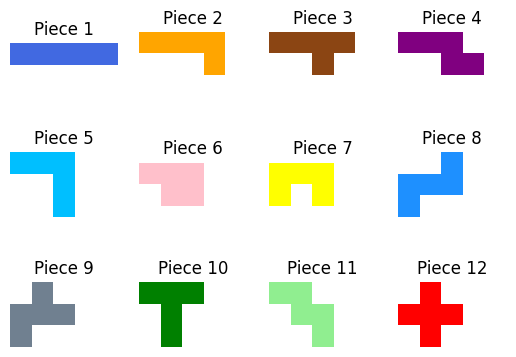

In [124]:
fig, axs = plt.subplots(3, 4)
for r in range(3):
    for c in range(4):
        i = r*4 + c 
        axs[r,c].imshow(PIECES[i+1].shape,cmap=CMAP,vmin=0,vmax=12)
        axs[r,c].set_title(f"Piece {i+1}")
        axs[r,c].axis('off')
plt.show()

## Choose which pieces and Solve

In [136]:
pieces = [1,2,3,4,5,6,7,8,9,10]#,11,12]
#pieces = [2,3,10,6,11,8,5,4]


260 states searched in 0.46 seconds


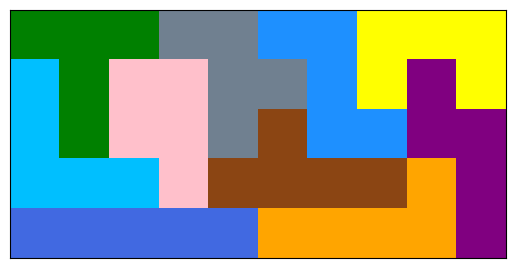

In [137]:
np.random.shuffle(pieces)
board = np.zeros((5,len(pieces))).astype(int)
start_state = (board,pieces)
solver = PathFinder(start_state,check_done,transition_func,hash_func,False)
solver.DFS()